In [2]:
import tensorflow as tf

In [3]:
import os
import pandas as pd

datadir = '/Users/kesavreddy/Downloads/DataJPG'
category_dirs = [d for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]

category_counts = pd.DataFrame({'Category': category_dirs,'Count': [len(os.listdir(os.path.join(datadir, d))) for d in category_dirs]})

In [4]:
category_counts

,Category,Count
0,G,28
1,A,127
2,E,3
3,B,18


In [5]:
img_size = 224

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

Found 42526 files belonging to 4 classes.
Using 34021 files for training.


2023-11-15 01:05:44.264478: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-15 01:05:44.264511: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-15 01:05:44.264523: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-15 01:05:44.264768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-15 01:05:44.264796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 42526 files belonging to 4 classes.
Using 8505 files for validation.


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import numpy as np

img_size = 224  # Specify the image size
batch_size = 32  # Specify your batch size
num_classes = 4  # Specify the number of classes

# Create a pre-trained DenseNet121 model (excluding the top classification layer)
base_model = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model using your TensorFlow datasets with callbacks
history = model.fit(
    train_ds,
    epochs=15,  # You can adjust the number of epochs
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(val_ds)
print("Test accuracy:", test_acc)

Epoch 1/15


2023-11-15 01:05:51.735816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - ETA: 0s - loss: 1.0468 - accuracy: 0.6821

2023-11-15 01:09:51.773004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - 300s 281ms/step - loss: 1.0468 - accuracy: 0.6821 - val_loss: 0.5577 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 2/15
1064/1064 [==============================] - 298s 280ms/step - loss: 0.7154 - accuracy: 0.7388 - val_loss: 0.7096 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 3/15
1064/1064 [==============================] - 308s 290ms/step - loss: 0.6384 - accuracy: 0.7609 - val_loss: 0.5952 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 4/15
1064/1064 [==============================] - 299s 281ms/step - loss: 0.5970 - accuracy: 0.7734 - val_loss: 0.4790 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 5/15
1064/1064 [==============================] - 298s 280ms/step - loss: 0.5763 - accuracy: 0.7835 - val_loss: 0.4253 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 6/15
1064/1064 [==============================] - 303s 285ms/step - loss: 0.5666 - accuracy: 0.7846 - val_loss: 0.4189 - val_accuracy: 0.8312 - lr: 0.0010
Epoch 7/15
1064/1064 [=======================

In [9]:
import matplotlib.pyplot as plt

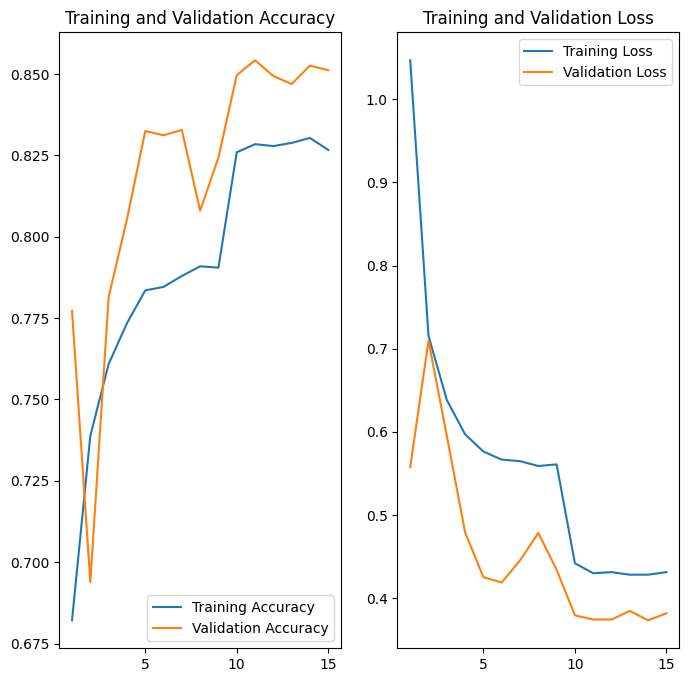

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Fix for the undefined 'epochs' variable
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
class_names = {
    'A': "Adinocarcinoma",
    'B': "Small Cell Carcinoma",
    'E': "Large Cell Carcinoma",
    'G': "Squamous Cell Carcinoma"
}


In [22]:
val_pred = model.predict(val_ds)
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

val_pred_labels = np.argmax(val_pred, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)

print("F1 score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))
print("Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(val_true_labels, val_pred_labels))

266/266 [==============================] - 88s 332ms/step
F1 score: 0.5823720023445704
Recall: 0.5845972957084068
Confusion Matrix:
 [[4602  457   21 1126]
 [ 494   49    0  135]
 [  17    4    0    4]
 [1152  119    4  321]]


In [15]:
def get_class_names_from_one_hot(encoded_labels, class_names):
    return [class_names[label] for label in np.argmax(encoded_labels, axis=1)]

In [23]:
y_true = []
y_pred = []

for x, y in val_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)

cm = confusion_matrix(y_true, y_pred)



1/1 [==============================] - 0s 21ms/step
Accuracy: 0.8511463844797178
Recall: 0.8511463844797178
F1 Score: 0.8504993955938672


In [16]:
model.save("VGG19.h5")
print("Model saved successfully.")

Model saved successfully.


/Users/kesavreddy/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
